# Classifying Model for County Mobility
State notebook purpose here

### Imports
Import libraries and write settings here.

In [3]:
#!pip install pydotplus

    100% |████████████████████████████████| 286kB 7.6MB/s ta 0:00:01
  Stored in directory: /Users/NateeAir/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [32]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling packages

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import statsmodels as sm 
import pydotplus 
from inspect import signature

# Options for pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

In [1]:
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

## Analysis/Modeling
Going to explore Random Forest and maybe logistic regression? 

### Setting up data

In [16]:
county_mobility = pd.read_pickle('../../data/02_intermediate/county_mobility_incomeOnly')

In [7]:
county_mobility.columns

Index(['County FIPS Code', 'County Name', 'Commuting Zone ID',
       'Commuting Zone Name ', 'State', 'Number of Children in Core Sample',
       'Rank-Rank Slope', 'Absolute Upward Mobility', 'Top 1% Income Share',
       'Interquartile Income Range', 'Gini', 'Teenage Birth Rate',
       'Share Between p25 and p75', 'Mean Parent Income', 'Mean Child Income',
       'Parent Income P25', 'Child Income P25', 'Median Parent Income',
       'Median Child Income', 'Parent Income P75', 'Child Income P75',
       'Parent Income P90', 'Child Income P90', 'Parent Income P99',
       'Child Income P99', 'rank_diff', 'Target'],
      dtype='object')

In [8]:
features = ['Top 1% Income Share','Interquartile Income Range', 'Median Parent Income']

In [17]:
X = county_mobility.dropna(subset=features, axis=0)[features]
y = county_mobility.dropna(subset=features, axis=0)[['Target']]

In [61]:
X.shape
y.shape

(2769, 3)

(2769, 1)

In [18]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5) 

#### SMOTE - Addressing Unbalanced Classes

In [77]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [85]:
smote = SMOTE(random_state=42)

In [86]:
X_res, y_res = smote.fit_resample(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [87]:
X_res.shape
y_res.shape
type(X_res)
type(y_res)

(3378, 3)

(3378,)

numpy.ndarray

numpy.ndarray

### Decision Tree 1

In [19]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
accuracy_score(y_test, y_pred)

0.8664259927797834

In [29]:
average_precision = average_precision_score(y_test, y_pred)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.23')

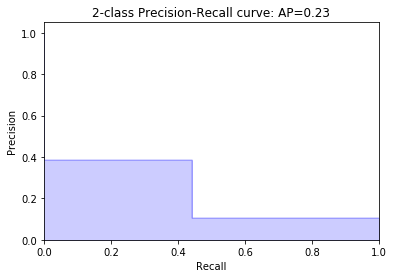

In [30]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [31]:
confusion_matrix(y_test, y_pred)
average_precision_score(y_test, y_pred)


array([[681,  62],
       [ 49,  39]])

0.23009471524769806

### Decision Tree 1 Summary

Initial model exploration: 

 - Split data into 70:30 Train:Test
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Null values were dropped
 - Only specified `criterion='entropy'`
 
Results: 
 - Model accuracy was 0.866 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.23 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - run same data through logistic regression which will report the likelihood of being classified as Mobile based on the combination of features


### Decision Tree 2

Given unbalanced class, used SMOTE to resample the da

### Logistic Regression 1

In [63]:
# Using sklearn first (but no p-values)
regr = LogisticRegression(C=1e5, solver='liblinear')

# train the model using the training sets
regr.fit(np.array(X_train), np.array(y_train).ravel())

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
prediction = regr.predict(X_test)

In [41]:
accuracy_score(y_test, prediction)

0.8856799037304453

In [42]:
average_precision_score(y_test, prediction)

0.1698595390560801

In [50]:
prob_X_test = []

for 
regr.predict_proba(X_test)[0][1] # probability that this county can be classified as Mobile based on the features

0.0035488980839694702

### Logistic Regression Plotting

In [51]:
from scipy.special import expit

In [72]:
# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
#plt.scatter(np.array(X).ravel(), np.array(y).ravel(), color='black', zorder=20)

loss = np.array(expit(X_test * regr.coef_ + regr.intercept_)).ravel()
plt.scatter(np.array(X_test).ravel(), loss, color='red', linewidth=3)

# ols = linear_model.LinearRegression()
# ols.fit(X, y)
# plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
# plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
# plt.xticks(range(-5, 10))
# plt.yticks([0, 0.5, 1])
# plt.ylim(-.25, 1.25)
# plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

<Figure size 288x216 with 0 Axes>

ValueError: Unable to coerce to Series, length must be 3: given 1

<Figure size 288x216 with 0 Axes>

In [ ]:
# Variables needed for plotting the distribution: 

# store the coefficients
coef = regr.coef_
interc = regr.intercept_
# create the linear predictor
lin_pred= (X * coef + interc)
# perform the log transformation
mod_income = 1 / (1 + np.exp(-lin_pred))
# sort the numbers to make sure plot looks right
age_ordered, mod_income_ordered = zip(*sorted(zip(age ,mod_income.ravel()),key=lambda x: x[0]))

X, 

In [ ]:
# Plotting the distribution

fig = plt.figure(figsize=(8,6))
fig.suptitle('logistic regression', fontsize=16)
plt.scatter(age, income_bin)
plt.xlabel("age", fontsize=14)
plt.ylabel("monthly income", fontsize=14)
plt.plot(age_ordered, mod_income_ordered, c = "black")
plt.show()

### Logistic Regression 1 Summary

Initial model exploration: 

 - Used same split data from decision tree: 
     - had to make the y_train a 1-d array
     - null values were dropped
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Only specified `C=1e5, solver='liblinear'`
 
Results: 
 - Model accuracy was 0.886 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.170 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - do SMOTE to addressed unbalanced classes


## Results
Show graphs and stats here

## Conclusions and Next Steps
Summarize findings here